<a href="https://colab.research.google.com/github/elpeme/w281_final_project/blob/main/Landmark_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import time
# import cv2
from sklearn.model_selection import train_test_split
from joblib import parallel_backend
import tensorflow as tf

import matplotlib.pyplot as plt
# import seaborn as sns
import textwrap

from keras.preprocessing import image
# %matplotlib inline

from skimage.feature import hog
from sklearn.metrics import accuracy_score
import pickle
import sklearn.svm as svm

import pandas as pd
import numpy as np
from PIL import Image
import PIL
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
import multiprocessing


2023-04-16 09:08:16.264720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# To use all available CPUs with Scikit learn
n_cpus = multiprocessing.cpu_count()
print('CPUs available: ', n_cpus)

CPUs available:  8


In [ ]:
# Enabling TPU
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)
print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)

Tensorflow version 2.12.0
Running on TPU  ['10.111.136.138:8470']
Number of accelerators:  8


In [3]:
# Load reduced and cleaned Landmark dataset from Google drive

# Load reduced Landmark dataset from local drive

local_path = './/'

train, test = train_test_split(pd.read_pickle("../top_20_df_w_images_arrays.pkl"), test_size=0.2, random_state=42, shuffle=True)

In [4]:
X_train = train['tiny_image'].values
Y_train = train['landmark_id'].values
X_test = test['tiny_image'].values
Y_test = test['landmark_id'].values
named_labels_train = train['category'].values
named_labels_test = test['category'].values

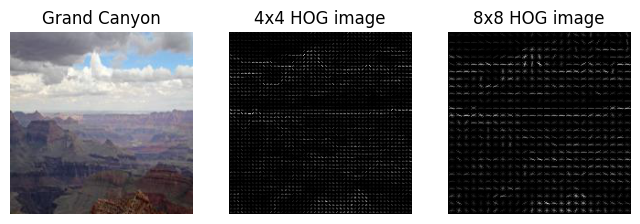

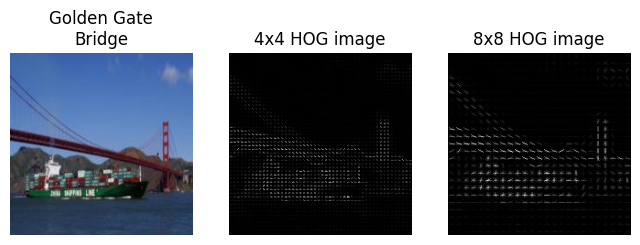

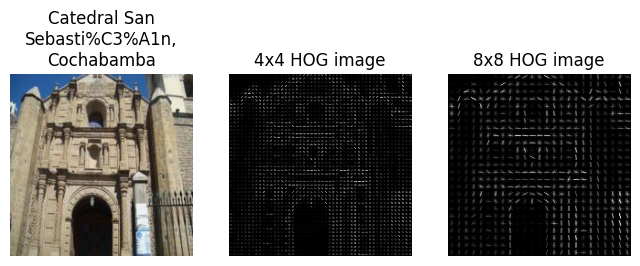

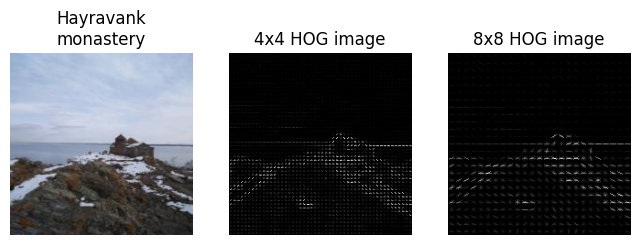

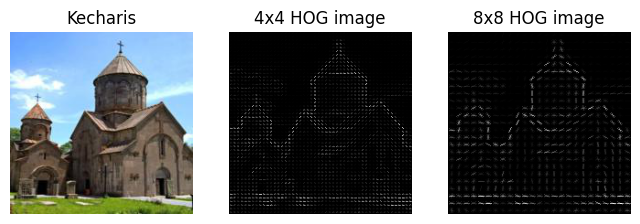

In [5]:


# Displaying HOG with Landmark dataset 5 random images 

wrapper = textwrap.TextWrapper(width=15, break_long_words=True)

def wrap_label(label):
  label = label.replace("_", " ")
  label = wrapper.wrap(label)
  return '\n'.join(label)


for i in range(5):
  image = X_train[i]
  fd_4x4, hog_img_4x4 = hog(image, orientations=9, pixels_per_cell=(4, 4),
                      cells_per_block=(2, 2), visualize=True, channel_axis = -1)
  fd_8x8, hog_img_8x8 = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis = -1)

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 8), sharex=True, sharey=True)

  ax1.axis('off')
  ax1.imshow(image, cmap=plt.cm.gray)
  wrapped_lable = wrap_label(named_labels_train[i])
  ax1.set_title(wrapped_lable)

      
  ax2.axis('off')
  ax2.imshow(hog_img_4x4, cmap=plt.cm.gray)
  ax2.set_title(f'4x4 HOG image')

  ax3.axis('off')
  ax3.imshow(hog_img_8x8, cmap=plt.cm.gray)
  ax3.set_title(f'8x8 HOG image')
  plt.show()

In [6]:
# Build HOG train and test arrays
with parallel_backend('threading', n_jobs = n_cpus):
    x_train_hog_np = np.array([hog(image, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=False, channel_axis = -1) for image in X_train])  

    x_test_hog_np = np.array([hog(image, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=False, channel_axis = -1) for image in X_test])  


In [9]:
with parallel_backend('threading', n_jobs = n_cpus):
  # SVM model
  hog_model = svm.SVC(kernel = 'rbf')
  hog_model.fit(x_train_hog_np , Y_train.ravel())
  svm_predict = hog_model.predict(x_test_hog_np)
  accuracy_svm = accuracy_score(Y_test , svm_predict)

  # Logistic regression model 
  logreg= LogisticRegression(max_iter=5000)
  logreg.fit(x_train_hog_np , Y_train.ravel())
  y_pred_logreg = logreg.predict(x_test_hog_np)
  accuracy_logreg = accuracy_score(Y_test , y_pred_logreg)

  # Random forest model
  rf = RandomForestClassifier()
  rf.fit(x_train_hog_np, Y_train.ravel())
  y_pred_rf = rf.predict(x_test_hog_np)
  accuracy_random_forest = accuracy_score(Y_test , y_pred_rf)


In [10]:
print("Accuracy with Landmark dataset")
print("SVM model: ", accuracy_svm)
print("Linear regression model: ", accuracy_logreg)
print("Random forest model: ", accuracy_random_forest)

Accuracy with Landmark dataset
SVM model:  0.46227832882476705
Linear regression model:  0.37932070934776074
Random forest model:  0.29155395250976857


In [12]:
# Save model and accuracy cresults
filename =  './' + 'hog_model_landmark.sav'
pickle.dump(hog_model, open(filename, 'wb'))


filename = './' + 'hog_model_landmark_predict.sav'
pickle.dump(svm_predict, open(filename, 'wb'))

filename =  './' + 'log_regression_model_landmark.sav'
pickle.dump(logreg, open(filename, 'wb'))


filename = './' + 'log_regression_model_landmark_predict.sav'
pickle.dump(y_pred_logreg, open(filename, 'wb'))

filename =  './' + 'random_forest_model_landmark.sav'
pickle.dump(rf, open(filename, 'wb'))


filename = './' + 'random_forest_landmark_predict.sav'
pickle.dump(y_pred_rf, open(filename, 'wb'))